# 109511276 練鈞揚
# HW 2 Part II : Classification
### Env : Anaconda Python 3.11

In [1]:
# rich print pretty
from rich import print as print , inspect


In [2]:
# from rich.traceback import install
# install(show_locals=True)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from dataclasses import dataclass
from collections import Counter
import seaborn as sns
from pprint import pformat
from scipy.stats import multivariate_normal
import scipy
from copy import deepcopy


In [4]:
data_df = pd.read_excel("HW2.xlsx")
data_df


,Unnamed: 0,x1,x2,class
0,0,18.73341,64.74255,1
1,1,3.99410,90.31358,1
2,2,23.39904,87.20672,1
3,3,24.83011,65.38512,1
4,4,13.73641,53.82633,1
...,...,...,...,...
995,995,54.10317,17.12986,4
996,996,93.22444,11.30329,4
997,997,86.16369,28.73599,4
998,998,79.43405,22.69025,4


### Type number

In [5]:
data_class_list = data_df['class']

count_dict = Counter(data_class_list)

set_of_class_type = set(data_class_list)
print(set_of_class_type)
print(count_dict)


TYPE_NUMBER = len(set_of_class_type)
COLOR_DICT = {1: "blue", 2: "green", 3: "red", 4: "black"}

{1, 2, 3, 4}

Counter({1: 400, 2: 250, 3: 200, 4: 150})

### build class

In [6]:
class BasketballPlayersDataControl:
            
    
    def __init__(self,data_load):  
        self.data_class_list = np.array([(row['x1'] , row['x2'] , int(row['class'] if row['class'] != 4 else 1)) for _, row in data_load])
        self.data_group_counter = Counter(list(map(int,self.data_class_list[:,2])))
        
        self.data_vec = np.array([self.data_class_list[:,0], self.data_class_list[:,1]]).T
        
        self.data_split_by_group = {
            class_number:
            np.array([(x1, x2) for x1 , x2 , c in self.data_class_list if c == class_number])
            for class_number in self.data_class_list[:,2]
        }
        
        self.t_format_dict = self.get_1_of_k_function()
        self.t_data_pool = np.array(list(map(self.t_format_dict.get , self.data_class_list[:,2])))
    
    def get_1_of_k_function(self):
        res = np.zeros(max(self.data_group_counter.keys()))
        def t_format(arr , number):
            arr[number - 1] = 1
            return arr
    
        return {
            key:
            t_format(deepcopy(res) , key)
            for key in self.data_group_counter.keys()
        }
    
    def get_data_vec(self):
        return self.data_vec
    
    def get_t_format_dict(self):
        return self.t_format_dict
    
    def get_data_t_format_data_pool(self):
        return self.t_data_pool
    
    def get_data(self):
        return self.data_class_list
    
    def __len__(self):
        return len(self.data_class_list)

    def get_data_group_counter(self):
        return self.data_group_counter
    
    def get_data_split_by_group(self):
        return self.data_split_by_group
    
    
    def plot_data(self):
        data_x1, data_x2 = self.data_class_list[:,0] , self.data_class_list[:,1] 
        data_color = list(map(COLOR_DICT.get, self.data_class_list[:,2]))
        
        plt.clf()
        plt.scatter(data_x1, data_x2, c=data_color)
        plt.title("Data")

        plt.xlabel("athleticism")
        plt.ylabel("skill")

        plt.show() 
        

In [7]:
bpd_data_list = BasketballPlayersDataControl(data_load=data_df.iterrows())

In [8]:
bpd_data_list.get_data_group_counter()

Counter({1: 550, 2: 250, 3: 200})

In [9]:
print({k :len(v) for k , v in bpd_data_list.data_split_by_group.items()})

{1.0: 550, 2.0: 250, 3.0: 200}

In [10]:
print(bpd_data_list.get_t_format_dict())

{1: array([1., 0., 0.]), 2: array([0., 1., 0.]), 3: array([0., 0., 1.])}

In [11]:
print(bpd_data_list.get_data_t_format_data_pool())

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]

In [12]:
print(bpd_data_list.get_data())

[[18.73341 64.74255  1.     ]
 [ 3.9941  90.31358  1.     ]
 [23.39904 87.20672  1.     ]
 ...
 [86.16369 28.73599  1.     ]
 [79.43405 22.69025  1.     ]
 [56.86633 17.46885  1.     ]]

In [13]:
print(bpd_data_list.get_data_vec())

[[18.73341 64.74255]
 [ 3.9941  90.31358]
 [23.39904 87.20672]
 ...
 [86.16369 28.73599]
 [79.43405 22.69025]
 [56.86633 17.46885]]

### plot data 

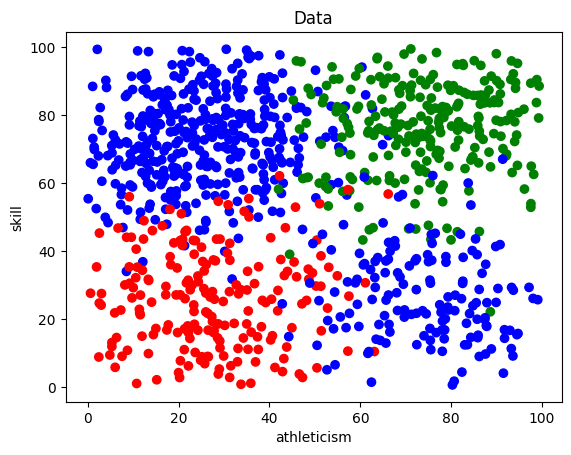

In [14]:
bpd_data_list.plot_data()

## Model 1 : Generative Model

#### Ref link
- https://wenwu53.com/classification-probabilistic-generative-model/
##### gaussian distribution
- http://cs229.stanford.edu/section/gaussians.pdf
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

In [15]:
class GenerativeModel:
    def __init__(self) -> None:
        # using the fit to find out 
        self.data_group_counter = None
        self.data_split_by_group = None
        self.group_number_list = None
        
        # for model 
        self.mean_dict = None 
        self.cov_matrix = None 
        self.pi_dict = None
        self.using_data = None

    def __init__(self ,bpd_data_control:BasketballPlayersDataControl) -> None:
        self.data_group_counter = bpd_data_control.get_data_group_counter()
        self.data_split_by_group = bpd_data_control.get_data_split_by_group()
        self.group_number_list = list(self.data_group_counter.keys())
    
    @classmethod
    def load_data(cls , bpd_data_control :BasketballPlayersDataControl):
        return cls(bpd_data_control)
    
    def find_mean(self):
        return {
            class_number:
            np.mean(line, axis=0)
            for class_number, line in self.data_split_by_group.items()
        }

    def group_pi_coef(self):
        N = sum(self.data_group_counter.values())
        
        N_class_list = list(np.array(list(self.data_group_counter.values())) / N)
        
        return dict(zip(self.group_number_list, N_class_list))

    def covariance_matrix(self):

        def build_group_matrix(group_of_matrix , group_mean, coef):
            matrix_term_list = [item_vec - group_mean
                                for item_vec in group_of_matrix]

            matrix_term_list = [
                item.reshape(-1, 1) @ [item] 
                for item in matrix_term_list
            ]
            
            sz = len(matrix_term_list)

            return coef * (1.0/sz) * np.sum(matrix_term_list ,axis=0)

        result_dict = {
            i:
            build_group_matrix(group_of_matrix=self.data_split_by_group[i],
                               group_mean=self.mean_dict[i],
                               coef=self.pi_dict[i])
            
            for i in self.group_number_list
        }

        return np.sum(list(result_dict.values()), axis=0)

    def fit(self):
        self.mean_dict = self.find_mean()
        
        self.pi_dict = self.group_pi_coef()
        
        self.cov_matrix = self.covariance_matrix()
        
        self.using_data = [(self.pi_dict[group] , self.mean_dict[group]) for group in self.group_number_list]
    
    def join_pdf(self, x):
        
        return np.array([pi_item * multivariate_normal.pdf(x=x , mean=mean_item , cov=self.cov_matrix) 

                         for pi_item, mean_item in self.using_data])
    
    def prediction(self , x):
        
        result_vector = (join_pdf_res := self.join_pdf(x=x)) / np.sum(join_pdf_res)
        
        return self.group_number_list[np.argmax(result_vector)]
    
    
    def __str__(self) -> str:
        return f"""
{GenerativeModel.__name__}
    
pi_dict : 
{pformat(self.pi_dict)}
    
mean_dict: 
{pformat(self.mean_dict)}, 
    
covariance matrix: 
{self.cov_matrix}"""


In [16]:
## testing

gm_model = GenerativeModel.load_data(bpd_data_list)

gm_model.fit()
print(gm_model)

GenerativeModel
    
pi_dict : 
{1: 0.55, 2: 0.25, 3: 0.2}
    
mean_dict: 
{1.0: array([39.06160684, 60.25114982]),
 2.0: array([74.157746  , 75.88818556]),
 3.0: array([27.40313325, 26.22084015])}, 
    
covariance matrix: 
[[ 440.36546081 -235.5252043 ]
 [-235.5252043   415.67967933]]

(2, 2)

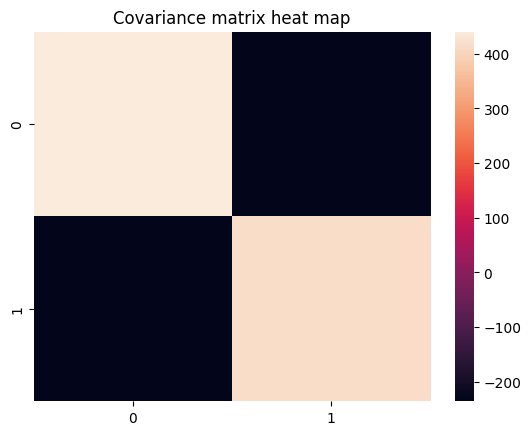

In [17]:
cov_matrix = gm_model.cov_matrix
print(cov_matrix.shape)
plt.clf()
plt.title("Covariance matrix heat map")
sns.heatmap(cov_matrix)

plt.show()

## Predict

In [18]:
def get_testing_point_in_space(x_space , y_space , step):
    test_x , test_y = np.linspace(0 , x_space + 1 , step), np.linspace(0 , y_space + 1 , step)
    test_xx , test_yy = np.meshgrid(test_x , test_y)
    return np.column_stack((test_xx.ravel(), test_yy.ravel()))

In [19]:
points = get_testing_point_in_space(100,100,100)

test_output_array = np.array([(point[0], point[1], gm_model.prediction(x=point)) for point in points])


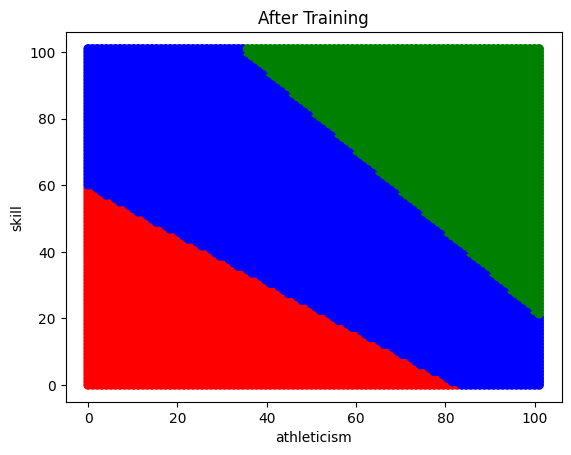

In [20]:
test_x1_list ,test_x2_list , test_group_list  = test_output_array[:,0] , test_output_array[:,1] , list(map(COLOR_DICT.get, test_output_array[:,2]))

plt.clf()

plt.scatter(test_x1_list, test_x2_list, c=test_group_list)
plt.title("After Training")

plt.xlabel("athleticism")
plt.ylabel("skill")

plt.show()

## Model 2 : Discriminative Model

### Ref
- https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/basis-functions.pdf
- https://www.youtube.com/watch?v=wq1K8F-S0AI

In [21]:
# import autograd.numpy as np
# from autograd import grad , hessian

In [41]:
class DiscriminativeModel:
   
    
    def __init__(self , M= 5) -> None:
        # about M 
        self.M = M
        
        # about data
        self.data_group_counter = None
        # self.data_split_by_group = None
        self.group_number_list = None
        
        # self.k_group_list: list = None
        self.weight_vec: np.ndarray = None
        self.t_format_base = None
        
        # data_pool
        self.t_data_pool = None
        self.y_data_pool = None
        self.phi_matrix = None
        self.mean_vector = None
        # using for the model  
        self.eye_matrix = None
    
    def __init__(self, bpd_data:BasketballPlayersDataControl):
        
        self.data_group_counter = bpd_data.get_data_group_counter()
        # self.data_split_by_group = bpd_data.get_data_split_by_group()
        self.group_number_list = list(self.data_group_counter.keys())
        
        
        
        self.mean_vector = np.array([
            np.mean(data_line, axis=0)
            for _ , data_line in bpd_data.get_data_split_by_group().items()
        ])
        
        self.basis_func_pdf_list = self.pdf_builder(bpd_data.get_data_vec())
        
        self.phi_matrix = np.array([
            self.basis_function_vector_builder(x=line_vec) 
            for line_vec in bpd_data.get_data_vec()
        ])
        
        # print(self.phi_matrix.shape)
        
        self.K = np.max(self.group_number_list)
        self.M = self.phi_matrix.shape[1]
        
        # using for the model  
        self.eye_matrix = np.eye(len(self.group_number_list))
        
        # init weight
        self.weight_vec = np.random.random(self.M*self.K).reshape(self.K , self.M)
        
        # t format base
        self.t_format_base = np.zeros(int(np.max(self.group_number_list)))
        
        # data_pool
        self.t_data_pool = bpd_data.get_data_t_format_data_pool()
        
        self.data_len = len(self.t_data_pool)
    
    
        
         
        # after predict
        self.y_data_pool = None
        
################################################################################################
    @classmethod
    def load_data(cls, bpd_data):
        return cls(bpd_data)

    def group_weight(self):
        return dict(zip(self.group_number_list, self.weight_vec))
    
################################################################################################
    def pdf_builder(self , data):
        cov = np.cov(data.T)
        
        print(cov)
        
        return [multivariate_normal(mean=mean_vector, cov=cov) 
                for mean_vector in self.mean_vector]
    
    
    @staticmethod
    def logic_sigmoid(a):
        return 1 /(1 + np.exp(-a))
    
    def basis_function_vector_builder(self, x):
        dis_vec = np.exp(np.array([
            pdf_function.pdf(x)
            for pdf_function in self.basis_func_pdf_list
        ]))
        
        dis_vec = dis_vec / np.sum(dis_vec)
        
        mean_dis = np.array([
            np.linalg.norm(x - mean_vector)
            for mean_vector in self.mean_vector 
        ])
        
        mean_dis = mean_dis / np.sum(mean_dis)
        
        manhattan_vec = np.array([
            np.sum(np.abs(x - mean_vector))
            for mean_vector in self.mean_vector 
        ])
        
        manhattan_vec = manhattan_vec /  np.sum(manhattan_vec)
        
        return np.concatenate([dis_vec , mean_dis , manhattan_vec], axis=0)
    
    
################################################################################################
    @staticmethod
    def softmax(ak_list):
        return (ak_exp := np.exp(ak_list - np.max(ak_list))) / np.sum(ak_exp, axis=0)
    
    # output a vector # k x 1 vector
    @staticmethod
    def ak_mapping_function(weight_list, basis_function_vec):
        return np.array([
            weight @ basis_function_vec
            for weight in weight_list
        ])
    
    # output a vector # k x 1 vector # with normalization
    @staticmethod
    def y_predict_with_softmax(weight_list, basis_function_vec):
        dm = DiscriminativeModel
        
        return dm.softmax(ak_list=dm.ak_mapping_function(weight_list, basis_function_vec))
    
################################################################################################
    @staticmethod
    def cross_entropy_error_function(true_output, prediction_output):
        return -np.sum(true_output * np.log(prediction_output))

    # is w_new  = w_old ....... thing 
    
    # output a 1D array [...]
    def gradient_E(self):
        yt_data_pool = self.y_data_pool - self.t_data_pool
        
        return np.array([
            # linear combination of vector
            yt_j_vec @ self.phi_matrix
            for yt_j_vec in yt_data_pool.T
            
        ]).flatten()
    
    # linear combination of matrix 
    def hessian_matrix_item(self, k, j):
        R_matrix = np.diag(self.y_data_pool[:,k] * (int(k==j) - self.y_data_pool[:,j]))
        
        return self.phi_matrix.T @ R_matrix @ self.phi_matrix
    
    def hessian_matrix_line(self, k):
        
        # R = lambda k , j : np.eye(self.data_len) * (self.y_data_pool[:,k] * (int(k==j) - self.y_data_pool[:,j]))
        
        # first to build a item matrix 
        hessian_matrix_line_res = np.array([
            # self.hessian_matrix_item(k=k,j=j)
            self.hessian_matrix_item(k,j)
            for j in range(self.K)
        ])
        
        # after np.concatenate((A, B), axis=1) # by column
        return np.concatenate(hessian_matrix_line_res, axis=1)
    
    def hessian_matrix(self):
        # first to build a line of matrix
        
        hessian_matrix_res = np.array([
            self.hessian_matrix_line(k=k)
            for k in range(self.K)
        ])
        
        # after np.concatenate((A, B), axis=0) # by row 
        return np.concatenate(hessian_matrix_res, axis=0)
    
################################################################################################
    
    def newton_raphson(self,threshold=0.1):
        losses = []
        all_weight_list = []# for save the different iterations weight
        
        W_vec = np.concatenate(self.weight_vec)
        # print(W_vec)
        
        while True:
            if len(losses) > 1 and (abs(losses[-2] - losses[-1]) <= threshold):
                break
            
            weight_list = np.split(W_vec, self.K)
            
            all_weight_list.append(deepcopy(W_vec))
            
            self.y_data_pool = np.array([
                
                self.y_predict_with_softmax(
                    weight_list=weight_list,
                    basis_function_vec=phi_line)
    
                for phi_line in self.phi_matrix
            ])

            loss_now = self.cross_entropy_error_function(true_output=self.t_data_pool,
                                                         prediction_output=self.y_data_pool)
            print(loss_now)
            
            losses.append(loss_now)
            
            del_E = self.gradient_E()
            H_matrix = self.hessian_matrix()
            
            # print(H_matrix.shape)
            
            W_vec -= np.linalg.pinv(H_matrix) @ del_E
            # W_vec -= self.inv(H_matrix) @ del_E
        
        # final to save the weight dict 
        self.weight_vec = np.split(W_vec,self.K)
        
        return losses, all_weight_list
    
    def fit(self, threshold=0.1):
        return self.newton_raphson(threshold=threshold)
    
    # result is a group number 
    def prediction(self , x):
        # weight_list
        
        x_basis_function_vector = self.basis_function_vector_builder(x=x)
        
        predict_result = self.y_predict_with_softmax(
            weight_list=self.weight_vec, 
            basis_function_vec=x_basis_function_vector)
        
        return self.group_number_list[np.argmax(predict_result)]
    
    
    def prediction_with_different_weight(self,x, test_weight):
        x_basis_function_vector = self.basis_function_vector_builder(x=x)
        test_weight = np.split(test_weight, self.K)
        
        predict_result = self.y_predict_with_softmax(
            weight_list=test_weight, 
            basis_function_vec=x_basis_function_vector)
        
        return self.group_number_list[np.argmax(predict_result)] 
    

In [42]:
d_model = DiscriminativeModel.load_data(bpd_data=bpd_data_list)

print(d_model.weight_vec)

[[ 7.34715178e+02 -3.15140497e-01]
 [-3.15140497e-01  7.00730559e+02]]

[[0.18729724 0.57016643 0.19463693 0.81755364 0.60237345 0.06056746
  0.19295491 0.18329785 0.13353367]
 [0.29911473 0.35128291 0.23347869 0.20626814 0.99787841 0.4567434
  0.12697494 0.65827607 0.29749051]
 [0.49227358 0.23973211 0.24563608 0.89844041 0.05007455 0.48979596
  0.56970852 0.18089732 0.12519886]]

In [43]:
test_it = d_model.phi_matrix

In [44]:
d_model.mean_vector

array([[39.06160684, 60.25114982],
       [74.157746  , 75.88818556],
       [27.40313325, 26.22084015]])

In [45]:
a = d_model.basis_function_vector_builder(np.array([1,2]))
a

array([1.00000734, 1.00000012, 1.00009078, 0.33231294, 0.49657347,
       0.17111359, 0.32761373, 0.50018573, 0.17220054])

In [46]:
d_model.ak_mapping_function(d_model.weight_vec,a)

array([1.71118217, 1.94820734, 1.68359343])

In [47]:
losses, weight_list_vec = d_model.fit(threshold=0.1)

1219.4534874358314

312.33210027195696

256.5986683872027

242.0587787687502

239.32237610799305

239.15102792957816

239.1500018150795

In [48]:
after_train_dict = dict(enumerate(zip(losses, weight_list_vec)))
print(after_train_dict)

{
    0: (
        1219.4534874358314,
        array([0.18729724, 0.57016643, 0.19463693, 0.81755364, 0.60237345,
       0.06056746, 0.19295491, 0.18329785, 0.13353367, 0.29911473,
       0.35128291, 0.23347869, 0.20626814, 0.99787841, 0.4567434 ,
       0.12697494, 0.65827607, 0.29749051, 0.49227358, 0.23973211,
       0.24563608, 0.89844041, 0.05007455, 0.48979596, 0.56970852,
       0.18089732, 0.12519886])
    ),
    1: (
        312.33210027195696,
        array([ 19476.13575868, -28420.59506332, -14445.09075444,  11697.41750973,
        11694.50267734,  11698.7873063 ,  11700.41609056,  11694.20809275,
        11695.06924163,  -8405.93738316,  28068.24173119,  -9427.88780295,
        -5116.23040986,  -5111.88219643,  -5121.86159553,  -5118.90853073,
        -5116.15075185,  -5115.57798176, -11069.14707797,    353.6047182 ,
        23873.76042588,  -6579.23364965,  -6580.98593005,  -6575.91099277,
        -6580.62767941,  -6577.05642232,  -6579.01772575])
    ),
    2: (
        256.5986683872027,
        array([ 27819.53412786, -37320.67168635, -18290.57877704,  13900.09329168,
        13894.97931873,  13899.95948696,  13903.58249502,  13894.2131064 ,
        13896.21914449, -12595.53911746,  28098.7350056 ,  -5022.36256166,
        -5240.01588436,  -5237.51898969,  -5242.40573106,  -5243.20857216,
        -5238.62851589,  -5238.76379236, -15222.9620577 ,   9223.17595222,
        23313.6704044 ,  -8658.11771329,  -8655.82829483,  -8656.5443108 ,
        -8659.50011491,  -8654.57738072,  -8656.98358799])
    ),
    3: (
        242.0587787687502,
        array([ 31370.26517437, -38040.81417317, -25838.37846331,  16259.85134954,
        16254.00705434,  16257.95571018,  16263.03424592,  16253.60133552,
        16254.11849387, -15220.70371191,  18269.7006986 ,   6585.24305627,
        -4817.70942237,  -4819.48780512,  -4813.01028981,  -4820.11554285,
        -4815.00744921,  -4815.71197717, -16148.62480746,  19772.37227032,
        19253.88544833, -11440.21951295, -11432.87456248, -11443.94576409,
       -11442.0356863 , -11437.60925781, -11437.95142963])
    ),
    4: (
        239.32237610799305,
        array([ 32138.61030453, -35205.45445987, -31475.02227754,  17277.0522468 ,
        17270.88519126,  17274.1035315 ,  17279.72998928,  17271.55032613,
        17269.67936255, -16315.17280608,   6943.5926191 ,  17012.1243171 ,
        -3821.37540294,  -3827.55822118,  -3810.32587739,  -3822.96188805,
        -3817.87182334,  -3819.00729913, -15822.26323672,  28263.31937919,
        14463.77976832, -13453.76363789, -13441.7053821 , -13462.76846272,
       -13455.85975544, -13452.66199079, -13450.18926358])
    ),
    5: (
        239.15102792957816,
        array([ 32206.11562325, -33702.80995343, -33339.50716615,  17424.40253604,
        17418.16145436,  17421.11877226,  17426.89235051,  17419.26604263,
        17416.44174364, -16628.33073458,   3529.84205395,  20020.10493644,
        -3462.06173506,  -3469.55863492,  -3449.17500513,  -3463.3907403 ,
        -3458.41202533,  -3459.55695014, -15576.63923122,  30174.41749959,
        13320.34964195, -13960.43262497, -13946.97946161, -13970.94915742,
       -13962.59453424, -13959.85698978, -13956.3750117 ])
    ),
    6: (
        239.1500018150795,
        array([ 32208.01272807, -33540.78386915, -33498.79621471,  17422.10137185,
        17415.85978821,  17418.78008628,  17424.57407424,  17416.99190256,
        17414.09308302, -16662.69103895,   3374.01634618,  20179.19758914,
        -3446.52414145,  -3454.08860514,  -3433.53571799,  -3447.83585341,
        -3442.8685039 ,  -3444.00819227, -15544.17311802,  30168.2198718 ,
        13320.5450721 , -13973.66948962, -13960.14852958, -13984.24924924,
       -13975.83143815, -13973.1273716 , -13969.57338982])
    )
}

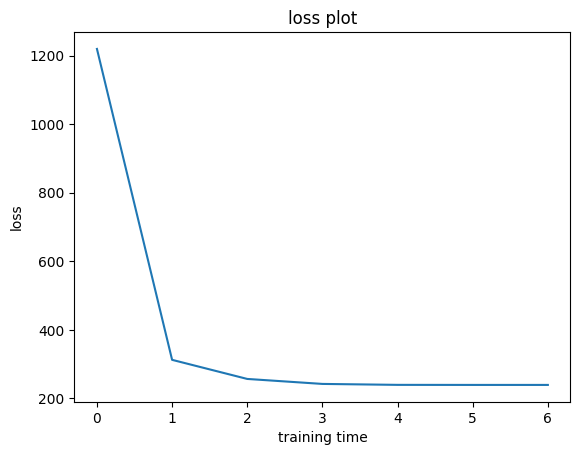

In [49]:
plt.clf()

pd.Series(losses).plot()
plt.title("loss plot")
plt.ylabel("loss")
plt.xlabel("training time")
plt.show()

In [50]:
points = get_testing_point_in_space(100,100,100)

# points

In [51]:
test_group_1 = bpd_data_list.data_split_by_group

In [52]:
for k , test_group in test_group_1.items():
    get = Counter([d_model.prediction(x=test_point) for test_point in test_group]).most_common()[0]
    print(f"pre-test {int(k)} : most comment {get}, acc = {get[1]/len(test_group) * 100} ")
    

pre-test 1 : most comment (1, 513), acc = 93.27272727272728

pre-test 2 : most comment (2, 218), acc = 87.2

pre-test 3 : most comment (3, 174), acc = 87.0

In [53]:
test_output_array = np.array([(point[0], point[1], d_model.prediction(x=point)) for point in points])


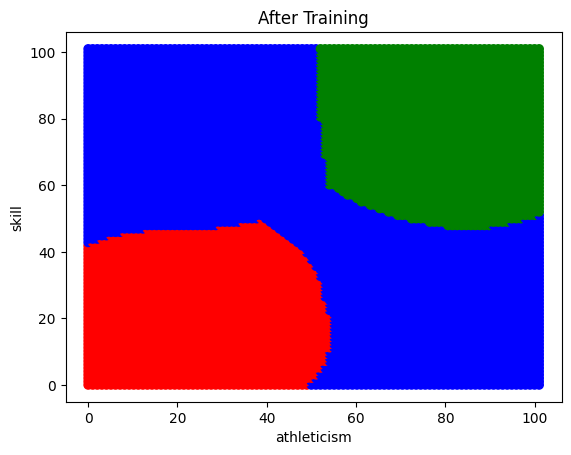

In [54]:
test_x1_list ,test_x2_list , test_group_list  = test_output_array[:,0] , test_output_array[:,1] , list(map(COLOR_DICT.get, test_output_array[:,2]))

plt.clf()

plt.scatter(test_x1_list, test_x2_list, c=test_group_list)
plt.title("After Training")

plt.xlabel("athleticism")
plt.ylabel("skill")

plt.show()

## Different weight 

In [55]:
from PIL import Image
import imageio
import os

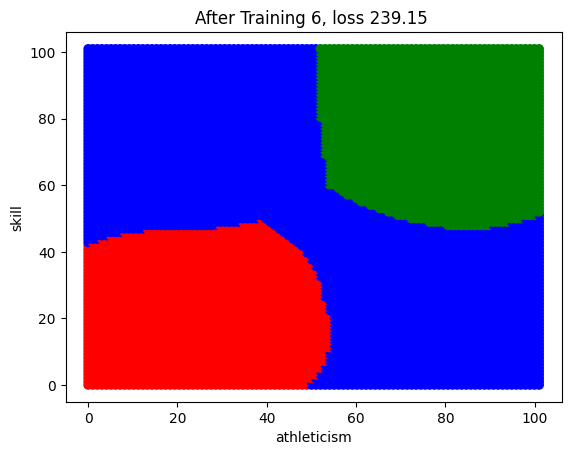

In [56]:
file_name = []

for index , (now_loss , weight_vec) in after_train_dict.items():
    
    test_output_array = np.array([
        (point[0], point[1], d_model.prediction_with_different_weight(x=point,test_weight=weight_vec)) 
        for point in points])


    test_x1_list ,test_x2_list , test_group_list  = test_output_array[:,0] , test_output_array[:,1] , list(map(COLOR_DICT.get, test_output_array[:,2]))

    plt.clf()

    plt.scatter(test_x1_list, test_x2_list, c=test_group_list)
    plt.title(f"After Training {index}, loss {now_loss:.2f} ")

    plt.xlabel("athleticism")
    plt.ylabel("skill")

    fig_filename = f"Part_II_figure_{index}.png"
    plt.savefig(fig_filename)
    file_name.append(fig_filename)
    
    
    # plt.show()

In [57]:
gif_filename = "PartII.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for fig_filename in file_name:
        image = Image.open(fig_filename)
        writer.append_data(np.array(image))
        image.close()


In [58]:
# delete the figure files
for fig_filename in file_name:
    os.remove(fig_filename)

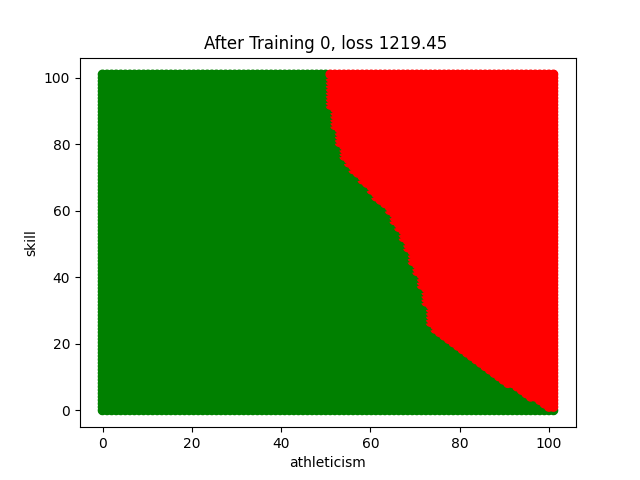

In [59]:
from IPython.display import Image
with open(gif_filename,'rb') as f:
    display(Image(data=f.read(), format='png'))